
**IMPLEMENTING A TRANSFORMER USING NUMPY**



In [ ]:
import numpy as np
import math

In [ ]:
L, d_k, d_v = 4, 8, 8

In [ ]:
Q = np.random.rand(L, d_k)
K = np.random.rand(L, d_k)
V = np.random.rand(L, d_v)

In [ ]:
Q.shape

(4, 8)

In [ ]:
K.shape

(4, 8)

In [ ]:
V.shape

(4, 8)

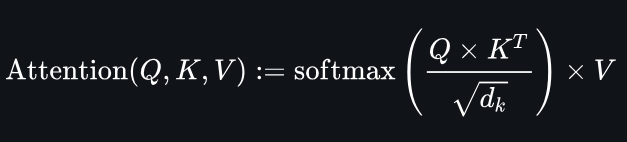

In [ ]:
np.matmul(Q, K.T)

array([[1.11142803, 1.43412031, 1.66853435, 2.59459217],
       [0.61776206, 1.31528896, 1.49935543, 2.09330633],
       [1.91797251, 1.21670864, 1.94019272, 3.11781054],
       [1.12746172, 0.77590392, 1.79231065, 2.64090133]])

In [ ]:
#Scaled term
scaled_term = np.matmul(Q, K.T) / np.sqrt(d_k)
scaled_term

array([[0.39294915, 0.5070381 , 0.58991598, 0.91732686],
       [0.21841187, 0.46502487, 0.53010219, 0.74009555],
       [0.67810569, 0.43017146, 0.68596171, 1.10231249],
       [0.39861791, 0.27432346, 0.63367751, 0.93369962]])

Now we implement context masking so that the system can only see a token and it's past, but not a future token.

In [ ]:
masker = np.tril(np.ones((L, L)))

In [ ]:
masker[masker == 0] = -np.inf
masker[masker == 1] = 0

In [ ]:
scaled_term + masker

array([[0.39294915,       -inf,       -inf,       -inf],
       [0.21841187, 0.46502487,       -inf,       -inf],
       [0.67810569, 0.43017146, 0.68596171,       -inf],
       [0.39861791, 0.27432346, 0.63367751, 0.93369962]])

In [ ]:
# Defining softmax function here
def softmax(x):
    x = x - x.max(axis=-1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=-1, keepdims=True)

In [ ]:
#Finally we reach self-attention
attention = softmax(scaled_term + masker)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.43865733, 0.56134267, 0.        , 0.        ],
       [0.35864169, 0.27988802, 0.36147029, 0.        ],
       [0.20594388, 0.18187311, 0.26051575, 0.35166725]])

With this, we got the similarity in vectors of one piece of data (basically text), with another

In [ ]:
#We can use this attention head to predict new values
new_V = np.matmul(attention, V)
print(new_V.shape)
new_V

(4, 8)


array([[0.25175886, 0.62693951, 0.47516866, 0.92613816, 0.10494182,
        0.48582979, 0.53651256, 0.56749366],
       [0.6674121 , 0.39157622, 0.23890205, 0.52897618, 0.17755345,
        0.58942104, 0.60375402, 0.59417485],
       [0.48916176, 0.32188045, 0.36538225, 0.53821828, 0.31211114,
        0.6332    , 0.72346756, 0.49456466],
       [0.48857605, 0.35147722, 0.44503318, 0.52882681, 0.50554614,
        0.58027252, 0.59691942, 0.63428093]])

In [ ]:
# MHA
L       = 3
d_model = 8
H       = 2
assert d_model % H == 0
d_head  = d_model // H

In [ ]:
np.random.seed(0)
X = np.arange(L * d_model, dtype=float).reshape(L, d_model) / 10.0

In [ ]:
#Projecting to Q, K, V in one step
W_qkv = np.random.randn(d_model, 3 * d_model) * 0.1

In [ ]:
#output proj
W_o   = np.random.randn(d_model, d_model) * 0.1

In [ ]:
#this is the SHA step where we project all Queries onto every Key
qkv = X @ W_qkv

In [ ]:
#now we split the Q, K, V vectors from the concatenated one
Q, K, V = np.split(qkv, 3, axis=-1)

In [ ]:
Q = Q.reshape(L, H, d_head).transpose(1, 0, 2)
K = K.reshape(L, H, d_head).transpose(1, 0, 2)
V = V.reshape(L, H, d_head).transpose(1, 0, 2)

Since we are performing operations on vectors, the dimensions need to align, which is why I reshaped a normal (L, d_head) shape matrix to (L, H, d_head). Just to keep track of "Which" head we're performing SHA on

In [ ]:
#Now we just perform classic attention
scores = Q @ K.transpose(0, 2, 1)
scores = scores / np.sqrt(d_head)
attention = softmax(scores)

In [ ]:
#calculating the new heads here
Y_heads = attention @ V

In [ ]:
Y_concat = Y_heads.transpose(1, 0, 2).reshape(L, d_model)

In [ ]:
Y = Y_concat @ W_o

In [ ]:
#Now lets just compress the code into usable functions...
def self_attention_single_head(X: np.ndarray, W_qkv: np.ndarray, W_o: np.ndarray | None = None, mask: np.ndarray | None = None):
    L, d_model = X.shape
    qkv = X @ W_qkv
    Q, K, V = np.split(qkv, 3, axis=-1)

    d_k = d_model
    scores = (Q @ K.T) / math.sqrt(d_k)
    if mask is not None:
        scores = scores + mask
    attn = softmax(scores)
    Y = attn @ V

    if W_o is not None:
        Y = Y @ W_o
    return Y, attn


In [ ]:
def multi_head_attention(X: np.ndarray, W_qkv: np.ndarray, W_o: np.ndarray, H: int, mask: np.ndarray | None = None):
    L, d_model = X.shape
    assert d_model % H == 0
    d_head = d_model // H

    qkv = X @ W_qkv
    Q, K, V = np.split(qkv, 3, axis=-1)

    Q = Q.reshape(L, H, d_head).transpose(1, 0, 2)
    K = K.reshape(L, H, d_head).transpose(1, 0, 2)
    V = V.reshape(L, H, d_head).transpose(1, 0, 2)

    #classic attn mechanism here.
    scores = Q @ K.transpose(0, 2, 1)
    scores = scores / math.sqrt(d_head)

    if mask is not None:
        if mask.ndim == 2:
            mask = np.broadcast_to(mask, scores.shape)
        scores = scores + mask

    attn = softmax(scores)

    Y_heads = attn @ V

    Y_concat = Y_heads.transpose(1, 0, 2).reshape(L, d_model)


    Y = Y_concat @ W_o

    return Y, attn
